In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow.keras import layers, models
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Data Loading

In [2]:
import os
import cv2
from tqdm import tqdm

# Image paths
imagePaths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    # Only process files inside the 'images' folder in the kaggle data
    if 'images' in dirname:
        for filename in filenames:
            if filename.endswith('png'):  # Consider only PNG files
                imagePaths.append(os.path.join(dirname, filename))

# Image Preprocessing

In [3]:
# Data - Label
Data = []
Target = []
resize = 150

# Label mapping dictionary
cat = {'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19'}

# Iterate through the image paths and assign the labels
for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-3]  # Extract the label from parent folder (2 levels up from image)
    
    if label not in cat:
        continue  # Skip this image if label is not found in dictionary
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) / 255.0  # Normalize image pixels to [0, 1]

    Data.append(image)
    Target.append(cat[label])

print(f"Processed {len(Data)} images with corresponding labels.")

100%|██████████| 21165/21165 [02:23<00:00, 147.42it/s]  

Processed 15153 images with corresponding labels.


In [4]:
print(len(Data))
print(len(Target))

15153
15153


# Label Encoding and to one hot encoding

In [5]:
le = LabelEncoder()
labels = le.fit_transform(Target)
labels = to_categorical(labels)

print(le.classes_)
print(labels[0])

['Covid-19' 'Normal' 'Pneumonia']
[0. 1. 0.]


# Splitting Dataset

In [6]:
# Initial split
(x_train, x_test, y_train, y_test) = train_test_split(Data, labels, test_size=0.20, stratify=labels, random_state=42)

# Further split the training data into training and validation sets
(x_train, x_val, y_train, y_val) = train_test_split(x_train, y_train, test_size=0.20, stratify=y_train, random_state=42)


trainX = np.array(x_train)
valX = np.array(x_val)
testX = np.array(x_test)
trainY = np.array(y_train)
valY = np.array(y_val)
testY = np.array(y_test)

print("Training data shape:", trainX.shape)
print("Validation data shape:", valX.shape)
print("Testing data shape:", testX.shape)
print("Training labels shape:", trainY.shape)
print("Validation labels shape:", valY.shape)
print("Testing labels shape:", testY.shape)

Training data shape: (9697, 150, 150, 3)
Validation data shape: (2425, 150, 150, 3)
Testing data shape: (3031, 150, 150, 3)
Training labels shape: (9697, 3)
Validation labels shape: (2425, 3)
Testing labels shape: (3031, 3)


# CNN Model Training

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

s = 150  # Size

model = Sequential()

# Feature Extraction Parts
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(s, s, 3), kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Dropout(0.25))

# Neural Network (Dense Layers)
model.add(Flatten()) 
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# Set early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with validation data and early stopping
epochs = 25
history = model.fit(
    trainX, trainY, 
    epochs=epochs, 
    batch_size=40, 
    verbose=1, 
    validation_data=(valX, valY),
    callbacks=[early_stopping]
)

Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.7450 - loss: 1.0321 - val_accuracy: 0.8928 - val_loss: 0.2880
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9002 - loss: 0.2535 - val_accuracy: 0.9142 - val_loss: 0.2316
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9301 - loss: 0.1947 - val_accuracy: 0.9278 - val_loss: 0.1966
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9515 - loss: 0.1412 - val_accuracy: 0.9262 - val_loss: 0.2082
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9632 - loss: 0.1053 - val_accuracy: 0.9435 - val_loss: 0.1596
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9742 - loss: 0.0727 - val_accuracy: 0.9468 - val_loss: 0.1508
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9762 - loss: 0.0729 - val_accuracy: 0.9456 - val_loss: 0.1621
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9801 - loss: 0.0535 - val_acc

# Extract accuracy and loss from the history object 

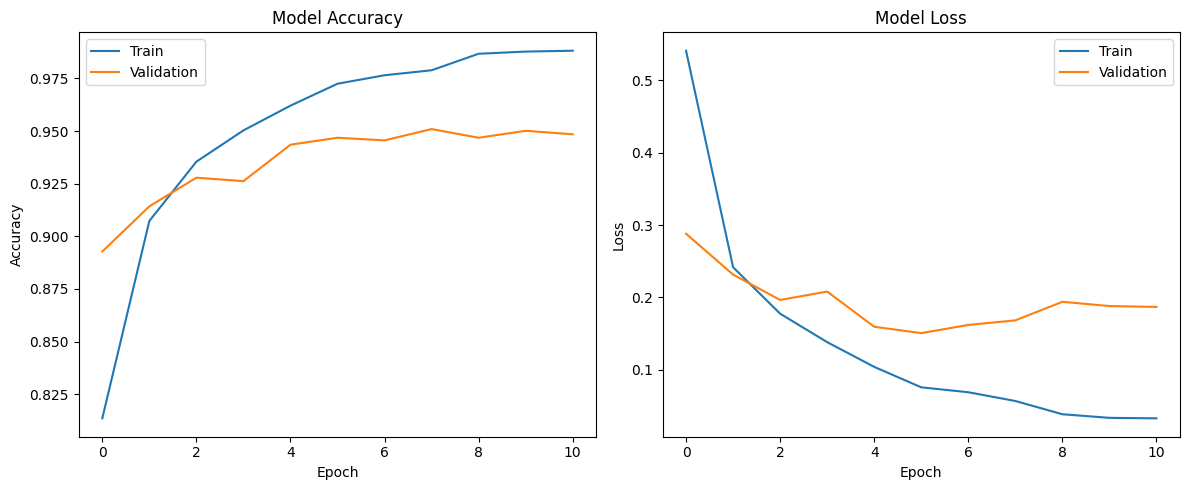

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

# Plotting Confusion Matrix

In [14]:
# Make predictions
predictions = model.predict(testX)
y_pred = np.argmax(predictions, axis=1)  # Convert predictions to class labels

# Convert testY from one-hot encoded to class labels (integers)
y_true = np.argmax(testY, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
[[ 645   75    3]
 [  41 1991    7]
 [   1   13  255]]


In [15]:
class_names = le.classes_

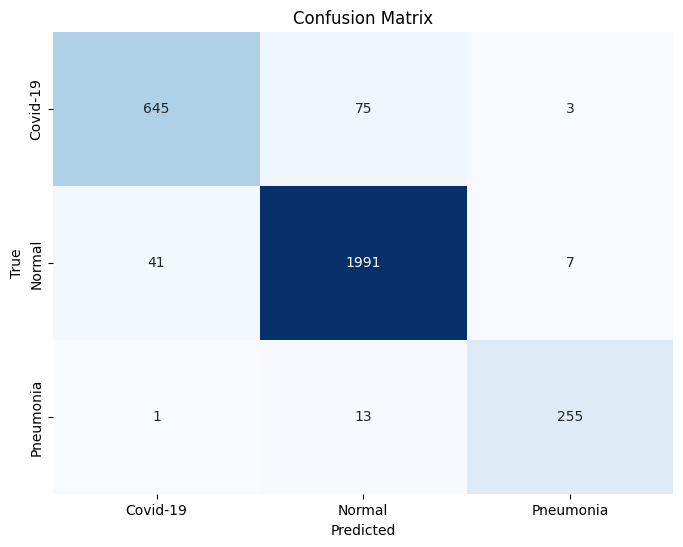

In [16]:
# Create DataFrame for the confusion matrix
Confusion_Matrix = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_Matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report on test

In [17]:
# predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(y_true, y_pred, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.93886   0.89212   0.91489       723
      Normal    0.95767   0.97646   0.96697      2039
   Pneumonia    0.96226   0.94796   0.95506       269

    accuracy                        0.95381      3031
   macro avg    0.95293   0.93884   0.94564      3031
weighted avg    0.95359   0.95381   0.95349      3031



# Save Model and Label Encoder

In [18]:
model.save('CNN_Covid19_Xray_Version.h5') 


import pickle

pickle.dump(le, open("Label_encoder.pkl",'wb'))
print("saved")

saved


# Load for inference

In [19]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('CNN_Covid19_Xray_Version.h5')

le = pickle.load(open("Label_encoder.pkl",'rb'))

# Real Time Detection System

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


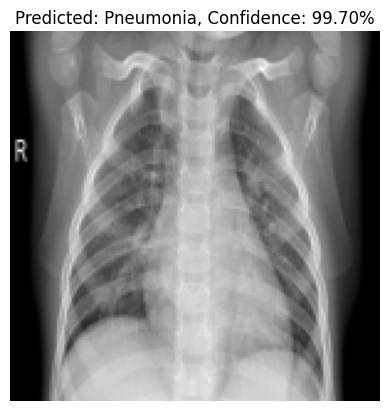

Predicted Label: Pneumonia, Confidence Score: 99.70%


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detection_system(image_path, model, label_encoder, image_size=150):
    """
    Detection system function to classify an input image.

    Parameters:
    - image_path: The path to the image to classify.
    - model: The trained Keras model.
    - label_encoder: The LabelEncoder used to encode the labels.
    - image_size: The target size for resizing the image (default: 150x150).
    
    Returns:
    - predicted_label: The predicted class label.
    - confidence_score: The confidence score of the predicted class.
    """
    # Load the image from the provided path
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    
    # Convert image from BGR to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image to the same size as the training images
    image_resized = cv2.resize(image_rgb, (image_size, image_size))
    
    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_resized / 255.0
    
    # Expand the dimensions to match the input shape for the model
    image_input = np.expand_dims(image_normalized, axis=0)
    
    # Predict the class of the image
    predictions = model.predict(image_input)
    
    # Get the predicted class index and confidence score
    predicted_index = np.argmax(predictions)
    confidence_score = predictions[0][predicted_index]
    
    # Decode the predicted index back to the original label
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]
    
    
    # Display the image with the predicted label and confidence score
    plt.imshow(image_resized)
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score*100:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence_score

# Example usage
image_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1000.png"  # Replace with the path to your image
predicted_label, confidence_score = detection_system(image_path, model, le)
print(f"Predicted Label: {predicted_label}, Confidence Score: {confidence_score*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


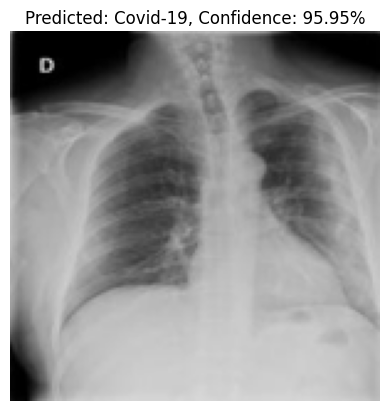

Predicted Label: Covid-19, Confidence Score: 95.95%


In [21]:
# Example usage
image_path ="/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1019.png"
predicted_label, confidence_score = detection_system(image_path, model, le)
print(f"Predicted Label: {predicted_label}, Confidence Score: {confidence_score*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


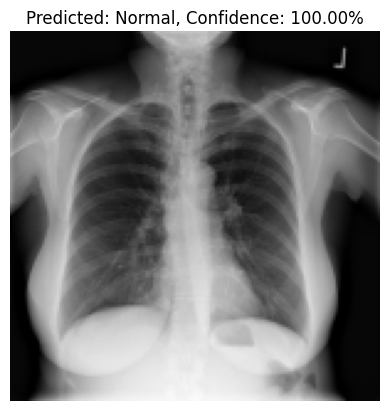

Predicted Label: Normal, Confidence Score: 100.00%


In [22]:
# Example usage
image_path ="/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10002.png"
predicted_label, confidence_score = detection_system(image_path, model, le)
print(f"Predicted Label: {predicted_label}, Confidence Score: {confidence_score*100:.2f}%")